In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydot
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)})
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from typing import *

from dtree import *

## Toy Example: 3-variable XOR
We will grow three decision trees to classify XOR data and save them to files.

In [2]:
X = np.array([[0, 0, 0], 
              [0, 1, 0], 
              [1, 0, 0], 
              [1, 1, 0], 
              [0, 0, 1], 
              [0, 1, 1], 
              [1, 0, 1], 
              [1, 1, 1]])

y = np.array([0, 1, 1, 0, 1, 0, 0, 1])

consxor3 = grow(X, y, np.array(list(range(len(y)))), lambda X, y: False)
shorxor3 = grow(X, y, np.array(list(range(len(y)))), leaves_too_small(2))
vshoxor3 = grow(X, y, np.array(list(range(len(y)))), leaves_too_small(4))

In [3]:
viscons = pydot.Dot(graph_type="digraph")
visualize(consxor3, viscons, y)
visshor = pydot.Dot(graph_type="digraph")
visualize(shorxor3, visshor, y)
visvsho = pydot.Dot(graph_type="digraph")
visualize(vshoxor3, visvsho, y)

(<pydot.Node at 0x7f9ff035db50>, 3)

In [4]:
viscons.write_png("consxor3.png")
visshor.write_png("shorxor3.png")
visvsho.write_png("vshoxor3.png")

## Real Example: Iris Data
Now we will do the same with the [Iris data set](https://archive.ics.uci.edu/ml/datasets/Iris). In addition, we will try to get the best accuracy and avoid overfitting by limiting tree depth and leaf sparsity, and using pruning. First let's visualize the data set to decide which variables we want to make a decision tree using.

In [5]:
iris = load_iris()
X, y = iris["data"], iris["target"]

# make a DataFrame for easy data manipulation and plotting
dat = pd.DataFrame(data=X,
                   columns=["Sepal length",
                            "Sepal width",
                            "Petal length",
                            "Petal width"])
dat["class"] = y

Text(0.5, 1.01, 'Predictors in the Iris Data Set')

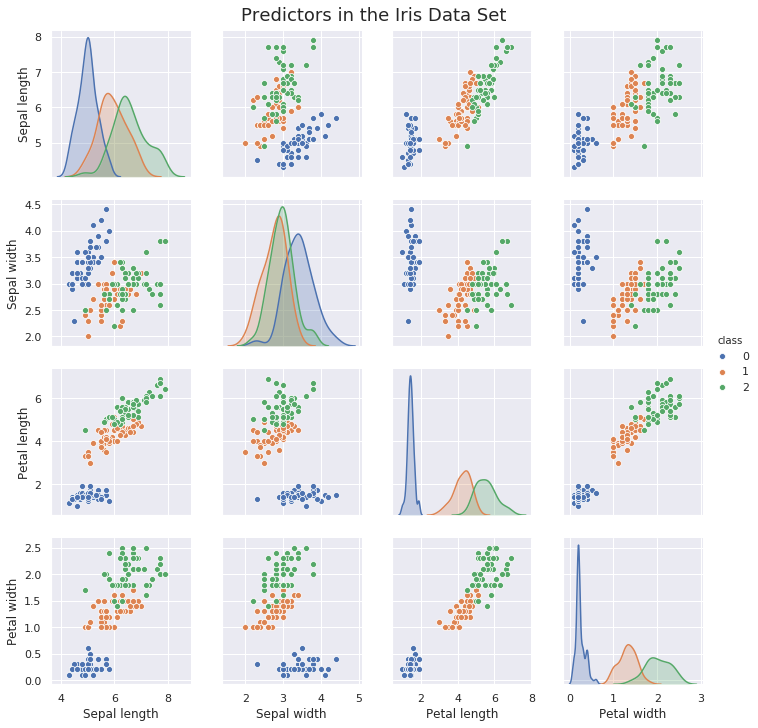

In [6]:
sns.pairplot(dat,
             vars=dat.columns[:4],
             hue="class").fig.suptitle("Predictors in the Iris Data Set",
                                       y=1.01, fontsize=18)

From the plot above we can see that while petal length and petal width are great predictors of flower species, sepal width is a particularly useless predictor. Hence, if we make a decision tree to predict flower species using sepal width only, then we will have to construct a relatively deep tree with many branches (and overfit the training data) to obtain high training accuracy. If we use sepal width and either petal length or width, then short trees should ignore sepal width altogether.

For ease of visualization we will use one or two predictors only, with flower species being the response variable. To make the data ~~impossible to classify perfectly using relatively short trees~~ *interesting*, we will try to predict flower species from sepal width and petal width.

Below is an example of a (subjectively) ideal decision tree that does not overfit the data, visualized. Observe that the leaf corresponding to class 1 is not pure.

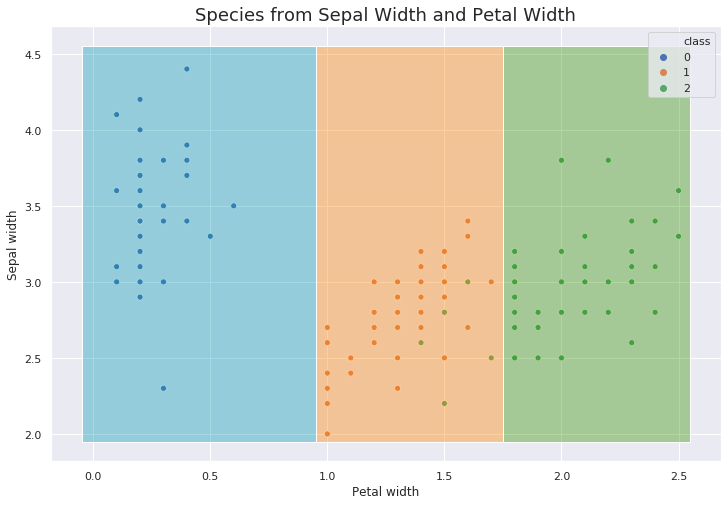

In [7]:
ax = sns.scatterplot(data=dat,
                     x="Petal width", y="Sepal width", hue="class",
                     palette=sns.color_palette(n_colors=3)
                    )
ax.set_title("Species from Sepal Width and Petal Width", fontsize=18)
ax.fill([-0.05, -0.05, 0.95, 0.95], [1.95, 4.55, 4.55, 1.95], "#0A9BB660",
        [0.95, 0.95, 1.75, 1.75], [1.95, 4.55, 4.55, 1.95], "#FF830060",
        [1.75, 1.75, 2.55, 2.55], [1.95, 4.55, 4.55, 1.95], "#30930060");

Below is an example of a decision tree that has (subjectively) overfit the training data, and has pure leaves. We can see that some of the leaves are tiny in terms of height, width, and number of points. These are hints to heuristics we might use to reduce overfitting. (Also, I hope you appreciate the arduous, annoying, time-consuming process that I had to follow to draw the rectangles.)

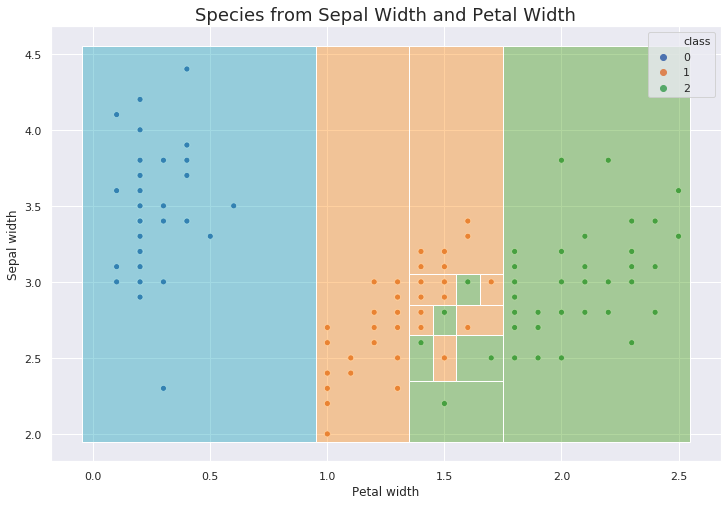

In [8]:
ax = sns.scatterplot(data=dat,
                     x="Petal width", y="Sepal width", hue="class",
                     palette=sns.color_palette(n_colors=3)
                    )
ax.set_title("Species from Sepal Width and Petal Width", fontsize=18)
ax.fill([-0.05, -0.05, 0.95, 0.95], [1.95, 4.55, 4.55, 1.95], "#0A9BB660",
        [0.95, 0.95, 1.35, 1.35], [1.95, 4.55, 4.55, 1.95], "#FF830060",
        [1.35, 1.35, 1.75, 1.75], [3.05, 4.55, 4.55, 3.05], "#FF830060",
        [1.35, 1.35, 1.55, 1.55], [2.85, 3.05, 3.05, 2.85], "#FF830060",
        [1.45, 1.45, 1.55, 1.55], [2.35, 2.65, 2.65, 2.35], "#FF830060",
        [1.55, 1.55, 1.75, 1.75], [2.65, 2.85, 2.85, 2.65], "#FF830060",
        [1.65, 1.65, 1.75, 1.75], [2.85, 3.05, 3.05, 2.85], "#FF830060",
        [1.35, 1.35, 1.45, 1.45], [2.65, 2.85, 2.85, 2.65], "#FF830060",
        [1.55, 1.55, 1.65, 1.65], [2.85, 3.05, 3.05, 2.85], "#30930060",
        [1.35, 1.35, 1.75, 1.75], [1.95, 2.35, 2.35, 1.95], "#30930060",
        [1.55, 1.55, 1.75, 1.75], [2.35, 2.65, 2.65, 2.35], "#30930060",
        [1.35, 1.35, 1.45, 1.45], [2.35, 2.65, 2.65, 2.35], "#30930060",
        [1.45, 1.45, 1.55, 1.55], [2.65, 2.85, 2.85, 2.65], "#30930060",
        [1.75, 1.75, 2.55, 2.55], [1.95, 4.55, 4.55, 1.95], "#30930060");

In [9]:
# clean_widths = dat[["Petal width", "Sepal width", "class"]
#                   ].drop_duplicates(subset=["Petal width", "Sepal width"], keep="last").values
clean_widths = dat[["Petal width", "Sepal width", "class"]
                  ].values
X2 = clean_widths[:, :2]
y2 = clean_widths[:, 2]
# y2 += np.random.randint(0, 3, y2.shape)

### Detour: Plotting Decision Boundaries
I brazenly stole the following function from Richard Johansson's post [here](http://www.cse.chalmers.se/~richajo/dit866/lectures/l3/Plotting%20decision%20boundaries.html). It makes a contour plot after evaluating the classifier at a bunch of points. I modified his code to iteratively evaluate the classifier since trees are not vectorizable in any easy way.

In [10]:
def plot_decision_boundary(clf, X, Y, cmap="gist_rainbow"):
    h = 0.02
    num_h = int(10 / h)
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    
    xx = np.linspace(x_min, x_max, num_h)
    yy = np.linspace(y_min, y_max, num_h)

    X_test = np.array(np.meshgrid(xx, yy)).reshape(2, -1).T
    
    y_test = np.empty((X_test.shape[0],), dtype=np.float64)
    for i in range(len(y_test)):
        y_test[i] = predict_iter(clf,
                                 X_test[i], 
                                 y2.astype(np.int64),
                                 lambda x: np.argmax(np.bincount(x)))  # plurality function
    y_test = y_test.reshape(num_h, num_h)

    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, y_test, cmap=cmap, alpha=0.3)
#     plt.contour(xx, yy, y_test, colors='k', linewidths=0.5, linestyles="dashed")
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap, edgecolors="k")
    plt.show()
    plt.close()

### The First Tree: Overfitting
This tree will have pure leaves, and hence will overfit (by my judgement, at least).

In [11]:
overfit_tree = grow(X2, y2, np.arange(len(y2)), lambda X, y: False, split_between=True)

In [12]:
vis = pydot.Dot(graph_type="digraph")
visualize(overfit_tree, vis, y2)
vis.write_png("overfit_tree.png")

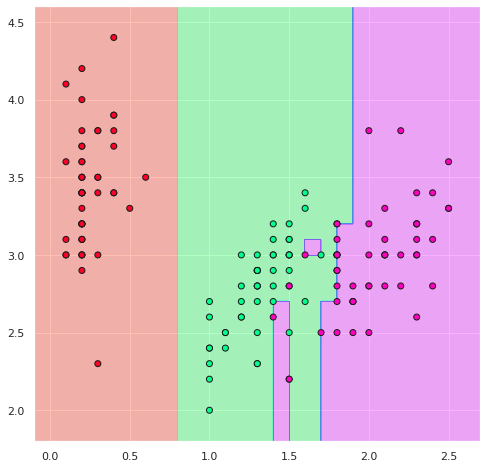

In [13]:
plot_decision_boundary(overfit_tree, X2, y2)

In [14]:
y_overfit = np.array([predict_iter(
    overfit_tree, x, y2.astype(int), lambda x: np.argmax(np.bincount(x))
) for x in X2])
accuracy_score(y_true=y2, y_pred=y_overfit)

0.98

The astute reader will notice that this is not the decision boundary I came up with in the previous, moreover, it seems that the point $(1.5, 2.8)$ is misclassified. Upon some investigation I found out that this data set actually has multiple overlapping observations, and hence the data is **impossible to classify with 100% accuracy**. The decision tree, thus, takes the majority vote at each leaf. It turns out that there is one green and one pink point at $(1.5, 2.8)$, and the tie gets broken in favor of green.

In [15]:
# overlapping training points
y2[np.logical_and(X2[:, 0] == 1.5, X2[:, 1] == 2.8)]

array([1., 2.])

### Limiting Depth
By limiting tree depth, we can avoid trees from becoming powerful enough to model the noise in the data, since the expressivity of a decision tree increases with increasing depth. By limiting tree depth to 2, we get precisely my ideal decision tree!

In [16]:
good_tree = grow(X2, y2, np.arange(len(y2)), lambda X, y: False, max_depth=2, split_between=True)

In [17]:
vis = pydot.Dot(graph_type="digraph")
visualize(good_tree, vis, y2)
vis.write_png("good_tree.png")

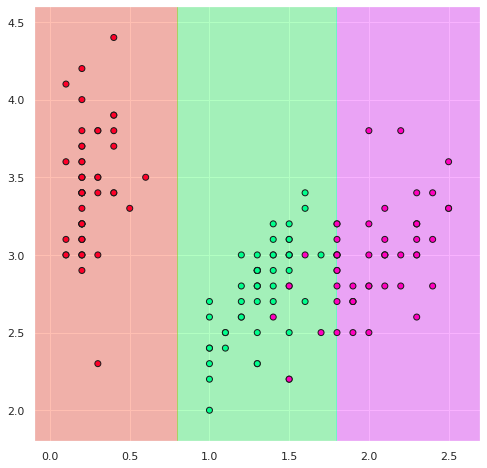

In [18]:
plot_decision_boundary(good_tree, X2, y2)

In [19]:
y_good = np.array([predict_iter(
    good_tree, x, y2.astype(int), lambda x: np.argmax(np.bincount(x))
) for x in X2])
accuracy_score(y_true=y2, y_pred=y_good)

0.96

### Limiting Leaf Sparsity
If we enforce a minimum number of elements per leaf node, then this also has a regularizing effect by preventing the decision tree from modeling noise which often manifests as a few points of a particular class in a region containing points mostly from another class. We enforce this using the `early_stop` function. Observe that by limiting the leaves to have at least 5 samples each, we get simpler decision boundaries than the overfitting tree, but this decision boundary still seems to be rather expressive. In order to be able to tell which one is better, though, we will need to do some (cross-)validation.

In [20]:
smallleaves_tree = grow(X2, y2, np.arange(len(y2)), leaves_too_small(threshold=5), split_between=True)

In [21]:
vis = pydot.Dot(graph_type="digraph")
visualize(smallleaves_tree, vis, y2)
vis.write_png("smallleaves_tree.png")

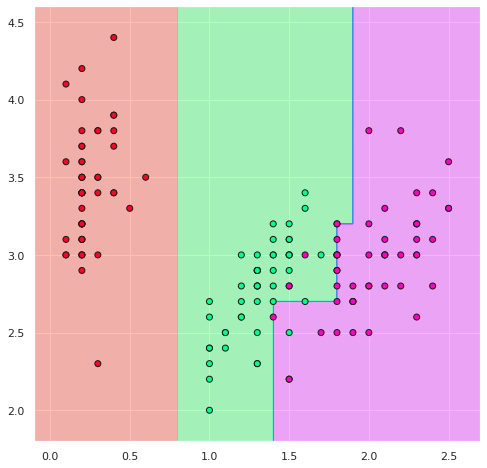

In [22]:
plot_decision_boundary(smallleaves_tree, X2, y2)

In [23]:
y_smallleaves = np.array([predict_iter(
    smallleaves_tree, x, y2.astype(int), lambda x: np.argmax(np.bincount(x))
) for x in X2])
accuracy_score(y_true=y2, y_pred=y_smallleaves)

0.9666666666666667

## Making it even more real: Validation
If you have been working in data science for any appreciable amount of time you must be cringing really hard at this point from me trying to judge overfitting vs. underfitting based on the decision boundary of the classifier. My point so far has really been to show how the complexity of the decision boundary changes as we change parameters of the model. I have been conjecturing about the fit of the model based on the intuition that models with the potential to produce more complex decision boundaries (i.e., more expressive hypothesis spaces) tend to overfit the training data. In this section, however, we will use validation to check whether this intuition is applicable in this case or not.

In [24]:
np.random.seed(2)
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.25)

In [25]:
overfit_tree = grow(X_train, 
                    y_train,
                    np.arange(len(y_train)),
                    lambda X, y: False,
                    split_between=True)
good_tree = grow(X_train, 
                 y_train,
                 np.arange(len(y_train)),
                 lambda X, y: False, max_depth=2,
                 split_between=True)
smallleaves_tree = grow(X_train,
                        y_train,
                        np.arange(len(y_train)),
                        leaves_too_small(threshold=5),
                        split_between=True)

In [26]:
trees = {"overfit_tree": overfit_tree,
         "good_tree": good_tree,
         "small_leaves_tree": smallleaves_tree}

for tree in trees:
    y_pred = np.array([predict_iter(
        trees[tree], x, y_train.astype(int), lambda x: np.argmax(np.bincount(x))
    ) for x in X_test])
    print(f"{tree} has test accuracy {accuracy_score(y_true=y_test, y_pred=y_pred)}")

overfit_tree has test accuracy 0.8947368421052632
good_tree has test accuracy 0.9473684210526315
small_leaves_tree has test accuracy 0.9210526315789473
